In [1]:
%matplotlib inline 
import gvxrPython3 as gvxr
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import copy
from skimage.transform import iradon
from math import floor

In [2]:
number_of_projections = 360;
projectionToVis = 25; #floor(number_of_projections/2);
rayEnergy = 73; 
angular_step = 180 / number_of_projections;
pixel_spacing_in_micrometre = 0.625;
gvxr.createWindow();
gvxr.setWindowSize(512, 512);
gvxr.setSourcePosition(0, -500, 0, "um");
gvxr.useParallelBeam();
gvxr.setMonoChromatic(rayEnergy, "keV", 1);
gvxr.setDetectorPosition(0, 500, 0, "um");
gvxr.setDetectorUpVector(0, 0, 1);
gvxr.setDetectorNumberOfPixels(150, 100);
gvxr.setDetectorPixelSize(0.625, 0.7, "um");

In [3]:

gvxr.makeCylinder("cyl", 20, 20, 10, "um");
gvxr.setHU("cyl", 500);
gvxr.makeCube("cube", 50, "um");
gvxr.setHU("cube", 100);

gvxr.addPolygonMeshAsOuterSurface("cube");
gvxr.addPolygonMeshAsInnerSurface("cyl");

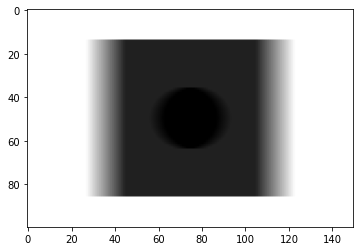

In [4]:
raw_projections = [];
theta = [];
for angle_id in range(0, number_of_projections):
    gvxr.rotateScene(-angular_step, 0, 0, 1);
    theta.append(-angular_step * angle_id);
    #gvxr.displayScene();
    xray_image = np.array(gvxr.computeXRayImage());
    raw_projections.append(xray_image);
    #plt.imshow(xray_image, cmap='gray');
    
raw_projections = np.array(raw_projections);
raw_projections = raw_projections / gvxr.getUnitOfEnergy("keV");

plt.imshow(raw_projections[projectionToVis], cmap='gray');
#gvxr.renderLoop();

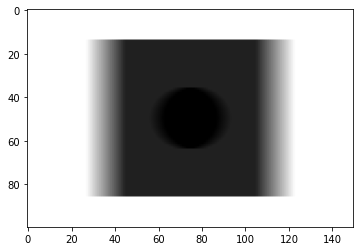

In [5]:
# Create a mock dark field image
dark_field_image = np.zeros(raw_projections.shape);

# Create a mock flat field image
flat_field_image = np.ones(raw_projections.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("keV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
corrected_projections = (raw_projections - dark_field_image) / (flat_field_image - dark_field_image);
    
plt.imshow(corrected_projections[projectionToVis], cmap='gray');

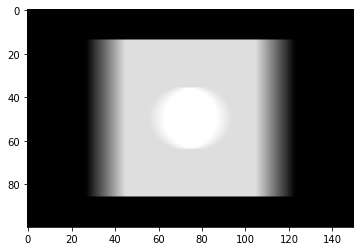

In [6]:

# Create a temporary image to hold the sinogram
simulated_sinogram = copy.deepcopy(corrected_projections);
    
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
simulated_sinogram[simulated_sinogram < threshold] = threshold;

# Apply the minus log normalisation
simulated_sinogram = -np.log(simulated_sinogram);

# Rescale the data taking into account the pixel size
simulated_sinogram /= pixel_spacing_in_micrometre * (gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm"));

plt.imshow(simulated_sinogram[projectionToVis], cmap='gray');

100
a
reconstructing slice #  50
done
mu air 0.00020984587536077015
mu water 0.19114477559924126


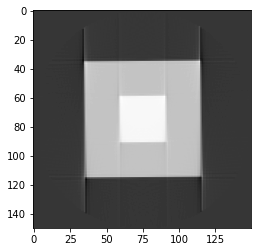

In [7]:
CT_slice_from_simulated_sinogram = [];
   
simulated_sinogram = np.swapaxes(simulated_sinogram, 0, 1); # slices as sinograms

print(len(simulated_sinogram));
slice = len(simulated_sinogram);

print("a");
slice = int(slice / 2);
print("reconstructing slice # ", slice);
CT_slice_from_simulated_sinogram.append(iradon(simulated_sinogram[slice].T, theta=theta, circle=True));
       
print("done");
# Save the CT slice
CT_slice_from_simulated_sinogram = np.array(CT_slice_from_simulated_sinogram);
    
    
    
volume = sitk.GetImageFromArray(CT_slice_from_simulated_sinogram);
volume.SetSpacing([0.625, 0.625, 0.7]);
sitk.WriteImage(volume, "recon_in_MU.mha", useCompression=True);

MU_air = gvxr.getMuFromHU(-1000.0, rayEnergy, "keV");
#MU_water = 1.707*0.1;
MU_water = gvxr.getMuFromHU(0, rayEnergy, "keV");
    
print("mu air", MU_air);
print("mu water", MU_water);
copied = copy.deepcopy(CT_slice_from_simulated_sinogram);
CT_slice_from_simulated_sinogram = 1000.0 * ((copied - MU_water) / (MU_water - MU_air));
    
volume = sitk.GetImageFromArray(CT_slice_from_simulated_sinogram);
volume.SetSpacing([0.625, 0.625, 0.7]);
sitk.WriteImage(volume, "recon_in_HU.mha", useCompression=True);
plt.imshow(CT_slice_from_simulated_sinogram[0], cmap='gray');